### Overlapping Outcomes

Chapter 3에서는 observation feature $X_i$에 label $y_i$를 배분했다. 여기서 $y_i$는 기간 $[t_{i,0}, t_{i, 1}]$ 내에서 발생한 가격 바의 함수였다. $t_{i,1} > t_{j,0}$이고 $i<j$이면 $y_i$와 $y_j$는 둘 다 공통 수익률 $r_{t_{j,0},\min\{t_{i,1}, t_{j,1}\}}$에 의존한다. 즉 구간 $[t_{j,0},\min\{t_{i,1}, t_{j,1}\}]$의 수익률이다. 이는 label의 계열 $\{y_i\}-{i, \dots, I}$는 두 연속 $y_i$에 중첩이 있을 때마다 IID가 아니라는 것을 암시한다.

이 문제를 해결하고자 베팅 기간을 $t_{i,1} \leq t_{i+1, 0}$으로 제한하는 방법을 생각해 보자. 이 경우 모든 feature의 출력은 다음 관측값 측정 이전이나 시작점에서 결정되므로 중첩은 발생하지 않는다. 이 방법은 특성의 표본 추출 빈도가 결과를 결정하고자 사용된 기간에 의해 제한되므로 조잡한 모델이 만들어질 것이다. 한편으로 한 달 동안 지속된 결과를 살펴보고자 할 경우 feature를 월 주기로 표본 추출해야 한다. 다른 한편으로 표본 추출 빈도를 일 단위로 증가시키면 출력의 기간을 1일로 축소해야 한다. 게다가 triple barrier와 같은 시간에 의존하는 labeling 기술을 사용하려면 표본 추출 주기는 처음 barrier에 도달하는 시간에 종속될 것이다. 어떤 경우들 concurrency를 없애려고 결과의 horizon을 제한하는 것은 형편없는 해법이다. $t_{i,1} > t_{i+1,0}$의 경우를 허용해야만 하고, 이 경우 앞에서 설명했던 concurrency의 문제가 또 다시 발생한다.

이런 상황이 금융을 응용할 때 나타나는 특징이다. 대부분의 비금융 분야의 머신러닝 연구자들은 관측값이 IID에서 추출한 것을 가정할 수 있다. 예를 들어서 혈액 샘플을 많은 환자에서 채집한 후에 콜레스트롤을 측정할 수 있다. 물론 콜레스테롤 분포의 평균과 표준 편차는 다양한 기저 공통 요인에 의해 변화하겠지만, 표본은 여전히 독립적이다. 하나의 대상자에 하나의 표본만 존재한다. 연구소의 누군가가 이 혈액 표본을 엎어서 각 튜브의 혈액이 오른쪽에 있는 9개의 튜브에 쏟아졌다고 생각해 보자. 튜브 10번은 10번환자의 혈액은 물론 1번부터 9번 환자까지의 혈액이 섞여 있고, 11번 튜브에는 11번환자와 함께 2번부터 10번까지의 환자의 혈액이 섞여 있다. 이제 각 환자의 콜레스트롤 수치를 모르는 상태에서 고 콜레스테로를 알아낼 수 있는 특성을 찾아내야 한다. 이는 금융 머신러닝이 처한 상황이라고 할 수 있다. 쏟아진 패턴도 제각각일 뿐만 아니라, 잘 알려져 있지도 한다. 금융 머신러닝 응용에 관해서는 plug and play방식이 적용되지 않는다. 이와 다르게 말하는 사람의 의견을 듣고 있다면 높은 확률로 돈과 시간을 낭비하는 것과 같다.

IID가 아닌 label을 다루는 데에는 여러가지 방법이 있고, chapter 4에서는 중첩된 결과의 지나친 영향을 교정하고자 표본 추출과 가중값 설계 방법으로 이 문제를 해결해 본다.

### Number of Concurrent Labels

두 label $y_i, y_j$가 **적어도 하나**의 공통 수익률 $r_{t-1, t} = \frac{p_t}{p_{t-1}} - 1$을 가지면 시간 $t$에서 공존한다(concurrent)라고 한다. 이 중첩은 시간 구간의 관점에서 해당 구간 너비가 서로 완벽하게 일치할 필요는 없다. 이 절에서는 주어진 수익률 $r_{t-1, t}$의 함수인 label의 개수를 계산해 본다.

1. 각 시간 $t = 1, \dots, T$에서 이진 행렬 ${1_{t,i}}_{i = 1,\dots, I}$를 구성하는데 여기서 $1_{t,i} \in \{0, 1\}$이다. 변수 $1_{t,i}$는 오직 $[t_{i,0}, t_{i,1}]$과 $[t-1, t]$가 중첩될 경우에만 그 값이 1이고, 그렇지 않다면 0이다. label의 폭 $\{[t_{i,0}, t_{i,1}]\}_{i=1,\dots,I}$는 Chapter 3에서 소개한 `t1` 객체에 정의된다는 것을 기억하자. 
2. 시간 $t, c_t = \sum_{i=1}^I 1_{t,i}$에서 concurrent label의 개수를 계산해 보자

$$c_t = \sum_{i=1}^I 1_{t,i}$$

아래의 코드는 이 로직을 구현한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from FinancialMachineLearning.sample_weights.concurrency import *
from FinancialMachineLearning.utils.multiprocess import *
from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility

start_date = '2000-01-01'
end_date = '2024-05-01'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 15 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-18
2000-01-04   2000-01-19
2000-01-05   2000-01-20
2000-01-06   2000-01-21
2000-01-07   2000-01-24
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [6]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [7]:
labels['bin'].value_counts()

 0    2132
 1    2084
-1    1892
Name: bin, dtype: int64

In [8]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [9]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

In [10]:
num_conc_events

Date
2000-01-03     0.0
2000-01-04     0.0
2000-01-05     0.0
2000-01-06     0.0
2000-01-07     1.0
              ... 
2024-04-24     7.0
2024-04-25     8.0
2024-04-26     9.0
2024-04-29    10.0
2024-04-30     8.0
Length: 6120, dtype: float64

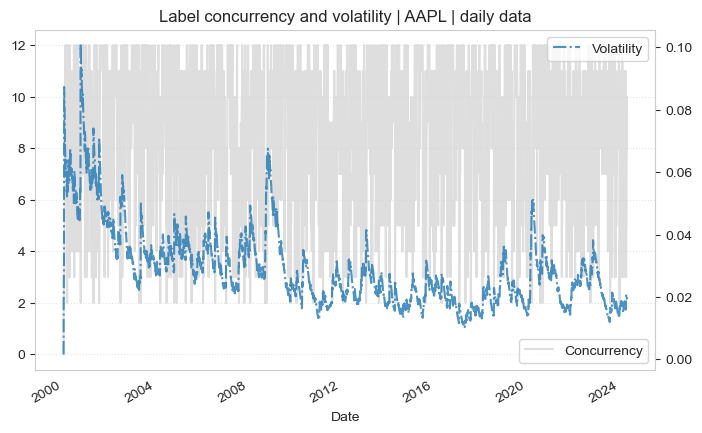

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
num_conc_events.plot(alpha = 0.75, color = 'lightgray', ax = ax)
plt.legend(['Concurrency'])

plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
    
volatility.plot(secondary_y = True, alpha = 0.8, ls = '-.', ax = ax)
plt.legend(['Volatility'])
plt.grid(False)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Label concurrency and volatility | AAPL | daily data')
plt.show()

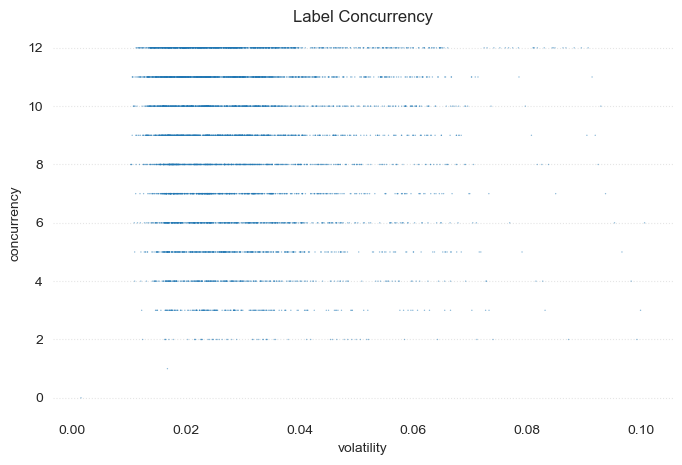

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.scatter(
    volatility[1:], num_conc_events[3:], 
    marker = '.', 
    alpha = 0.5, 
    edgecolor = 'none', 
    s = 4
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('volatility')
plt.ylabel('concurrency')
plt.title('Label Concurrency')
plt.show()

### Average Uniqueness of a Label

이번 절에서는 label의 비중첩도(고유도)를 전체 주기 동안의 평균 고유도로서 계산해 본다

1. 첫째, 시각 $t$에서 label $i$의 고유도는 $u_{t,i} = 1_{t,i}^{-1}$이다. 
2. label $i$의 평균 고유도는 label의 주기 동안의 평균 $u_{t,i}$이다. 

$$\bar{u_i} = \left( \sum_{t=1}^T u_{t,i}\right) \left( \sum_{t=1}^T 1_{t,i}\right)^{-1}$$

이 평균 고유도는 이벤트의 기간 동안 $c_t$의 조화 평균의 역수로 해석할 수도 있다. 아래의 그림은 객체 `t1`에서 도출된 고유도 값을 히스토그램으로 나타낸 것이다.

In [20]:
avg_unique = mp_pandas_obj( # average uniqueness
    average_uniqueness, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    label_endtime = triple_barrier_events['t1'], 
    num_conc_events = num_conc_events
)
avg_unique.head()

Date
2000-01-07    0.611111
2000-01-10    0.388889
2000-01-11    0.333333
2000-01-12    0.416667
2000-01-13    0.395833
dtype: float64

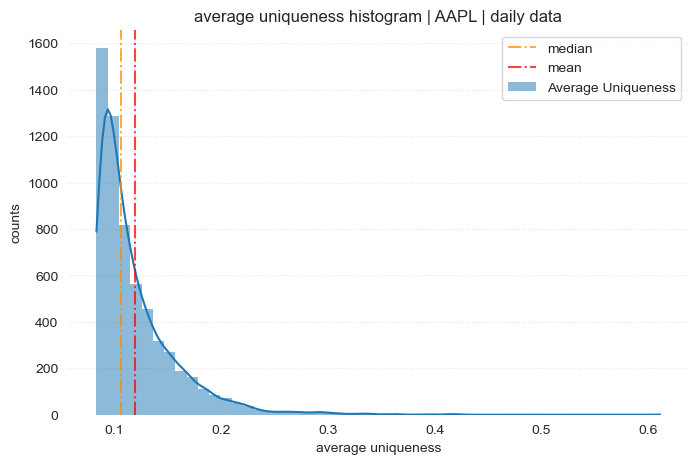

In [34]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (8, 5))
sns.histplot(
    avg_unique,
    bins = 50,
    edgecolor = 'none',
    kde = True,
    label = 'Average Uniqueness',
)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.axvline(
    avg_unique.median(), 
    color = 'darkorange', 
    alpha = 0.75, 
    ls = '-.', 
    label = 'median'
)
plt.axvline(
    avg_unique.mean(), 
    color = 'red', 
    alpha = 0.75,
    ls = '-.', 
    label = 'mean'
)
plt.legend()
plt.xlabel('average uniqueness')
plt.ylabel('counts')
plt.title('average uniqueness histogram | AAPL | daily data')
plt.show()

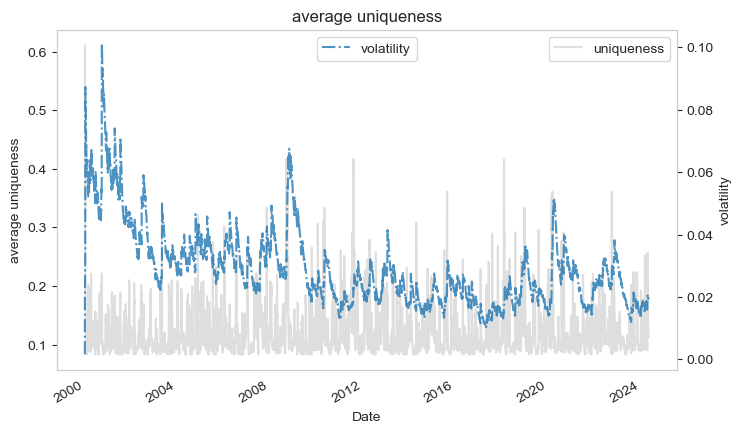

In [24]:
fig, ax = plt.subplots(figsize = (8, 5))
avg_unique.plot(alpha = 0.75, ax = ax, color = 'lightgray')
plt.legend(['uniqueness'])
plt.grid(False)
plt.ylabel('average uniqueness')

volatility.plot(secondary_y = True, alpha = 0.8, ax = ax, ls = '-.')
plt.legend(['volatility'], loc = 'upper center')
plt.grid(False)
plt.title('average uniqueness')
plt.xlabel('concurrency')
plt.ylabel('volatility')
plt.show()

label의 평균 고유도는 volatility와 대응되는 개념이므로, 시계열 메모리를 갖는 특성이 있다

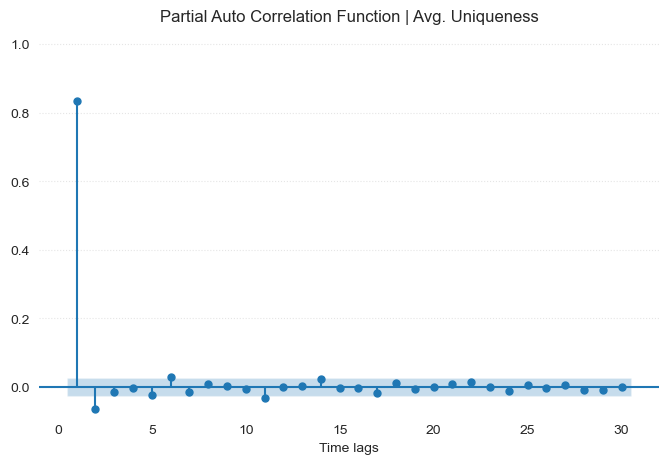

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(avg_unique, auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function | Avg. Uniqueness')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

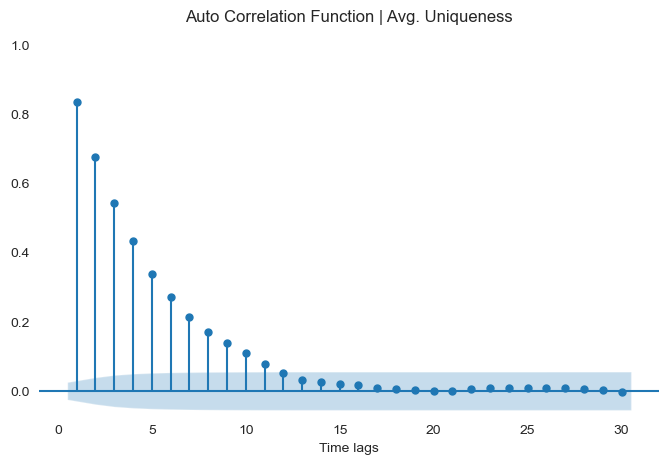

In [35]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(avg_unique, auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function | Avg. Uniqueness')
plt.show()

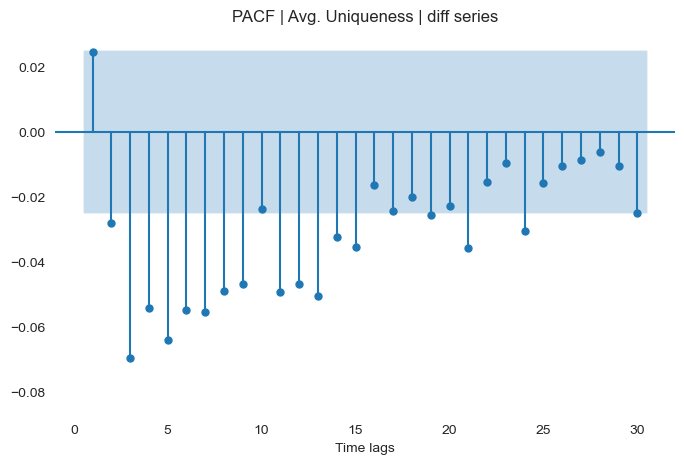

In [36]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('PACF | Avg. Uniqueness | diff series')
plt.show()

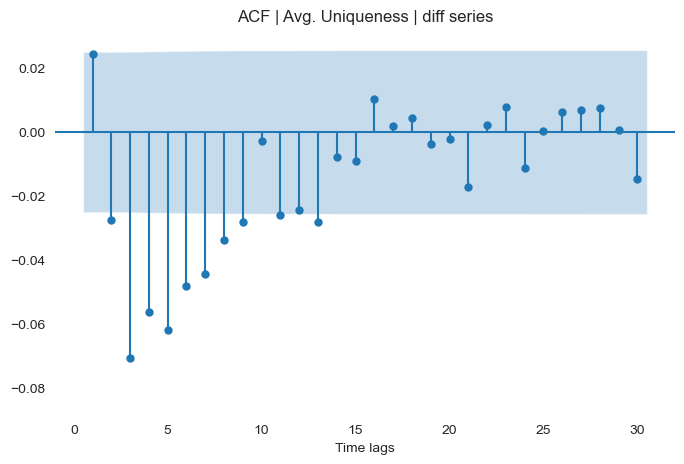

In [37]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(avg_unique.pct_change().dropna(), auto_ylims = True, lags = range(1, 31), ax = ax)
plt.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.xlabel('Time lags', fontsize = 10)
plt.title('ACF | Avg. Uniqueness | diff series')
plt.show()